In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.callbacks import EarlyStopping
from PIL import Image

2024-05-16 14:14:18.132056: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 14:14:28.688667: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mccdual2080/anaconda3/envs/cropImage/lib/python3.8/site-packages/cv2/../../lib64:
2024-05-16 14:14:28.689162: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mccdual2080/anaconda3/envs/cropImage

In [2]:
def gray_quantized(img, palette):
  rows, cols = len(img), len(img[0])
  total_vals = 1
  for i in palette.shape:
    total_vals *= i
  palettedata = palette.reshape(total_vals).tolist()
  palImage = Image.new('L', (rows, cols))
  palImage.putpalette(palettedata*32)
  oldImage = Image.fromarray(img, 'L')
  newImage = quantizetopalette(oldImage,palImage, mode="L")
  res_image = np.asarray(newImage)
  return res_image

#Función para dada una paleta solo tomar los colores de esa paleta en la imagen
def quantizetopalette(silf, palette, dither=False, mode="P"):
  """Convert an RGB or L mode image to use a given P image's palette."""
  silf.load()
  palette.load()
  im = silf.im.convert(mode, 0, palette.im)
  # the 0 above means turn OFF dithering making solid colors
  return silf._new(im)

#Toma todos los colores existentes en la imagen
def get_colors(image):
  aux = []
  band = True
  for i in image:
    for j in i:

      for k in aux:
        if j.tolist() == k:
          band = False
          break
      if band:
        aux.append(j.tolist())
      band = True
  return np.array(aux)

def recolor_greys_image(data, palette):
    rows, cols = len(data), len(data[0])
    aux = np.zeros((rows, cols), dtype=np.uint64)
    for i in range(rows):
        for j in range(cols):
            aux[i,j] = min(palette, key= lambda x:abs(x-data[i,j]))
    return aux

def recolor_greys_image1(data, palette):
    # Asegurarse de que la paleta y los datos estén en el mismo tipo de datos y rango
    palette = np.array(palette, dtype='float32')
    data = data.astype('float32')
    
    # Expandir las dimensiones de los datos y la paleta para la transmisión (broadcasting)
    data_expanded = data[:, :, np.newaxis]  # Forma ahora es (rows, cols, 1)
    palette_expanded = palette[np.newaxis, np.newaxis, :]  # Forma ahora es (1, 1, num_colors)
    
    # Calcular la diferencia absoluta entre cada píxel y cada color de la paleta
    abs_diff = np.abs(data_expanded - palette_expanded)
    
    # Encontrar el índice del color más cercano en la paleta para cada píxel
    indices_of_nearest = np.argmin(abs_diff, axis=2)
    
    # Mapear los índices a los valores de la paleta para obtener la imagen recoloreada
    recolored_image = palette[indices_of_nearest]
    
    return recolored_image

def agroup_window(data, window):
    new_data = [data[i:window+i] for i in range(len(data)-window+1)]
    return np.array(new_data)


In [3]:

categories = [0, 35, 70, 119, 177, 220, 255]
categoriesBalanced = [18, 54, 90, 126, 162, 198, 234]
channels = 1
window = 10
rows = 120
cols = 360
patience = 10
bach_size = 2
learning_rate = 0.005
epochs = 300

linkDeGuardado = "Resultados/ModelosAutoencoder/"

#leer una entrada de usuario por consola para variable de carpeta
carpeta = input("Ingrese el nombre de la carpeta: ")
print(carpeta)

#crear carpeta si no existe
if not os.path.exists(linkDeGuardado+carpeta):
  os.makedirs(linkDeGuardado+carpeta)
else:
   print("La carpeta ya existe")

linkDeGuardado = "Resultados/ModelosAutoencoder/"+carpeta

V4W10D30X90F4


In [4]:
#carga de datos ya procesados
x = np.load("/media/mccdual2080/Almacenamiengto/SahirProjects/SahirReyes/dataSetAutoencoder/DatasetAutoencoder/DataSetLatentSpace/Npy/Balanced/V1/Dataset120x360GreysNewCategories.npy")
print(x.shape)
print("min", np.min(x))
print("max", np.max(x))

(1254, 120, 360)
min 18.0
max 234.0


In [5]:
x = x/255
print (x.shape)
print ("type of x: ", x.dtype)
x_train = x[:int(len(x)*.7)]
x_test = x[int(len(x)*.7):]
x_validation = x_train[int(len(x_train)*.8):]
x_train = x_train[:int(len(x_train)*.8)]
#x_train = x_train.reshape(len(x_train), window, rows, cols, channels)
#x_validation = x_validation.reshape(len(x_validation), window, rows, cols, channels)
#x_test = x_test.reshape(len(x_test), window, rows, cols, channels)

print("Forma de datos de entrenamiento: {}".format(x_train.shape))
print("Forma de datos de validación: {}".format(x_validation.shape))
print("Forma de datos de pruebas: {}".format(x_test.shape))

print("colores de la imagen de entrenamiento: ", get_colors(x_train[150]))
print("colores de la imagen de validación: ", get_colors(x_validation[100]))
print("colores de la imagen de pruebas: ", get_colors(x_test[100]))

#save the data
#np.save("DataSetLatentSpace/Npy/Dataset120x360GreysTrain.npy", x_train)
#np.save("DataSetLatentSpace/Npy/Dataset120x360GreysValidation.npy", x_validation)
#np.save("DataSetLatentSpace/Npy/Dataset120x360GreysTest.npy", x_test)

(1254, 120, 360)
type of x:  float32
Forma de datos de entrenamiento: (701, 120, 360)
Forma de datos de validación: (176, 120, 360)
Forma de datos de pruebas: (377, 120, 360)
colores de la imagen de entrenamiento:  [0.07058824 0.91764706 0.63529414 0.7764706  0.49411765 0.35294119
 0.21176471]
colores de la imagen de validación:  [0.07058824 0.91764706 0.63529414 0.7764706  0.49411765 0.35294119
 0.21176471]
colores de la imagen de pruebas:  [0.07058824 0.91764706 0.7764706  0.63529414 0.49411765 0.35294119
 0.21176471]


In [6]:
input_shape = (120, 360, 1)

encoder_input = keras.Input(shape=input_shape)
print ("entrada encoder",encoder_input.shape)
x = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(encoder_input)
print("x conv",x.shape)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
print("x maxpool",x.shape)
x = layers.Conv2D(4, (3, 3), activation="relu", padding="same")(x)
print("x conv",x.shape)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
print("x maxpool",x.shape)
encoder_output = layers.Conv2D(4, (3, 3), activation="sigmoid", padding="same")(x)
print("salida encoder",encoder_output.shape)

# Definir la arquitectura del decoder
decoder_input = keras.Input(shape=encoder_output.shape[1:])
print ("entrada decoder",decoder_input.shape)
x = layers.Conv2D(4, (3, 3), activation="relu", padding="same")(decoder_input)
print("x conv",x.shape)
x = layers.UpSampling2D((2, 2))(x)
print("x upsample",x.shape)
x = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(x)
print("x conv",x.shape)
x = layers.UpSampling2D((2, 2))(x)
print("x upsample",x.shape)
#x = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(x)
decoder_output = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)  # Output 
print("salida decoder",decoder_output.shape)


entrada encoder (None, 120, 360, 1)


2024-05-16 14:16:07.612341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-16 14:16:07.613000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-16 14:16:08.024419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-16 14:16:08.025263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-16 14:16:08.026069: I tensorflow/compiler/xla/stream_executo

x conv (None, 120, 360, 8)
x maxpool (None, 60, 180, 8)
x conv (None, 60, 180, 4)
x maxpool (None, 30, 90, 4)
salida encoder (None, 30, 90, 4)
entrada decoder (None, 30, 90, 4)
x conv (None, 30, 90, 4)
x upsample (None, 60, 180, 4)
x conv (None, 60, 180, 8)
x upsample (None, 120, 360, 8)
salida decoder (None, 120, 360, 1)


In [7]:

strategy = tf.distribute.MirroredStrategy()
# Crear el encoder y el decoder como modelos de Keras
encoder = keras.Model(encoder_input, encoder_output, name="encoder")
decoder = keras.Model(decoder_input, decoder_output, name="decoder")

# Crear el autoencoder concatenando el encoder y el decoder

autoencoder_input = keras.Input(shape=input_shape)
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)
optim=Adam(learning_rate=learning_rate)#0.0005
autoencoder = keras.Model(autoencoder_input, decoded, name="autoencoder")
autoencoder.compile(optimizer=optim, loss="binary_crossentropy")

print ("xtrain",x_train.shape)
print ("xvalidation",x_validation.shape)


early_stopping = EarlyStopping(monitor='val_loss',  # Métrica a monitorear
                               patience=patience,         # Número de épocas sin mejora después de las cuales se detendrá el entrenamiento
                               restore_best_weights=True)  # Restaurar los mejores pesos.
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=patience) #monitor='val_loss', factor=0.2, patience=5, min_lr=0.001
# guardar en un archivo txt el historial de entrenamiento
history = autoencoder.fit(x=x_train, y=x_train, epochs=epochs, batch_size=bach_size, validation_data=(x_validation, x_validation), callbacks=[early_stopping, reduce_lr])

#encoder.save(linkDeGuardado + "/Encoder.h5")
#decoder.save(linkDeGuardado + "/Decoder.h5")


with open(os.path.join(linkDeGuardado, "training_history.txt"), "w") as f:
  f.write("Loss\n")
  f.write(str(history.history['loss']) + '\n')
  f.write("Validation Loss\n")
  f.write(str(history.history['val_loss']) + '\n')
  f.write("Learning Rate\n")
  f.write(str(history.history['lr']) + '\n')
  f.write("Epochs\n")
  f.write(str(history.epoch) + '\n')

    #autoencoder.fit(x= x_train,y= x_train,epochs=epochs, batch_size=bach_size,validation_data=(x_validation, x_validation),callbacks=[early_stopping,reduce_lr])


# guardar en un archivo txt el resumen del modelo autoencoder y los datos de entrenamiento
with open(os.path.join(linkDeGuardado, "autoencoder_summary.txt"), "w") as f:
    autoencoder.summary(print_fn=lambda x: f.write(x + '\n'))
    f.write(f"batch_size: {bach_size}\n")
    f.write(f"epochs: {epochs}\n")
    f.write(f"learning_rate: {learning_rate}\n")
    f.write(f"patience: {patience}\n")
    f.write(f"early_stopping: {early_stopping}\n")
    f.write(f"reduce_lr: {reduce_lr}\n")
    f.write(f"optimizer: {optim}\n")
    f.write(f"loss: {'binary_crossentropy'}\n")
    f.write("\n\n")
    f.write(f"Training data shape: {x_train.shape}\n")
    f.write(f"Validation data shape: {x_validation.shape}\n")
    f.write(f"Test data shape: {x_test.shape}\n")
    f.write("\n\n")
    "decoder",decoder.summary(print_fn=lambda x: f.write(x + '\n'))
    f.write("\n\n")
    "encoder",encoder.summary(print_fn=lambda x: f.write(x + '\n'))
    f.write("\n\n")


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
xtrain (701, 120, 360)
xvalidation (176, 120, 360)
Epoch 1/300


2024-05-16 14:16:47.265587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-05-16 14:16:57.664164: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-05-16 14:17:12.761992: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f57aba51a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-16 14:17:12.762039: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): GeForce RTX 2080 Ti, Compute Capability 7.5
2024-05-16 14:17:12.762052: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): GeForce RTX 2080 Ti, Compute Capability 7.5
2024-05-16 14:17:1

351/351 [==============================] - 40s 5ms/step - loss: 0.4465 - val_loss: 0.3776 - lr: 0.0050
Epoch 2/300
351/351 [==============================] - 1s 4ms/step - loss: 0.3781 - val_loss: 0.3729 - lr: 0.0050
Epoch 3/300
351/351 [==============================] - 1s 4ms/step - loss: 0.3756 - val_loss: 0.3712 - lr: 0.0050
Epoch 4/300
351/351 [==============================] - 1s 4ms/step - loss: 0.3748 - val_loss: 0.3714 - lr: 0.0050
Epoch 5/300
351/351 [==============================] - 1s 4ms/step - loss: 0.3740 - val_loss: 0.3702 - lr: 0.0050
Epoch 6/300
351/351 [==============================] - 1s 4ms/step - loss: 0.3735 - val_loss: 0.3698 - lr: 0.0050
Epoch 7/300
351/351 [==============================] - 1s 4ms/step - loss: 0.3730 - val_loss: 0.3695 - lr: 0.0050
Epoch 8/300
351/351 [==============================] - 2s 4ms/step - loss: 0.3728 - val_loss: 0.3692 - lr: 0.0050
Epoch 9/300
351/351 [==============================] - 2s 4ms/step - loss: 0.3726 - val_loss: 0.368

In [8]:
autoencoder.summary()

encoder.save(linkDeGuardado+"/encoder.h5")
decoder.save(linkDeGuardado+"/decoder.h5")
autoencoder.save(linkDeGuardado+"/autoencoder.h5")

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 360, 1)]     0         
                                                                 
 encoder (Functional)        (None, 30, 90, 4)         520       
                                                                 
 decoder (Functional)        (None, 120, 360, 1)       517       
                                                                 
Total params: 1,037
Trainable params: 1,037
Non-trainable params: 0
_________________________________________________________________


In [9]:
latent= encoder.predict(x_test)
recontructed_imgs= decoder.predict(latent)
img_og=x_test[0]
img_reconstructed=recontructed_imgs[0]
print(img_reconstructed.shape)
#img_og=np.squeeze(img_og)
#img_reconstructed=np.squeeze(img_reconstructed)
# cargar las imágenes originales y reconstruidas
print("reconstruida shape",recontructed_imgs.shape)
print ("latent",latent.shape)

12/12 [==============================] - 0s 5ms/step
(120, 360, 1)
reconstruida shape (377, 120, 360, 1)
latent (377, 30, 90, 4)


In [10]:
print("xtest unit",x_test.dtype)
print("recontructed unit",recontructed_imgs.dtype)
print("latent unit",latent.dtype)

xtest unit float32
recontructed unit float32
latent unit float32


In [11]:
print("minimo y maximo de la imagen original: ", np.min(img_og), np.max(img_og))
print("minimo y maximo de la imagen reconstruida: ", np.min(img_reconstructed), np.max(img_reconstructed))
print("dtype de la imagen original: ", img_og.dtype)
print("dtype de la imagen reconstruida: ", img_reconstructed.dtype)

minimo y maximo de la imagen original:  0.07058824 0.91764706
minimo y maximo de la imagen reconstruida:  0.0086911395 0.99284416
dtype de la imagen original:  float32
dtype de la imagen reconstruida:  float32


latent shape (30, 90, 4)


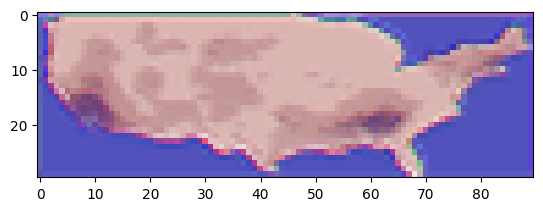

recontructed_imgs shape (120, 360, 1)


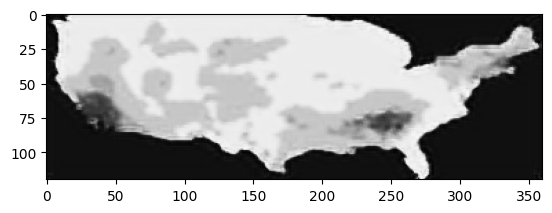

x_test shape (120, 360)


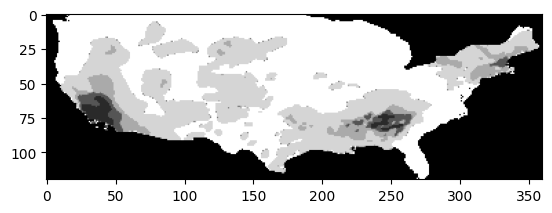

In [12]:
print("latent shape",latent[0].shape)
plt.imshow(latent[0], cmap='gray')
plt.show()

print("recontructed_imgs shape",recontructed_imgs[0].shape)
plt.imshow(recontructed_imgs[0], cmap='gray')
plt.show()

print("x_test shape",x_test[0].shape)
plt.imshow(x_test[0], cmap='gray')
plt.show()

stop paso1

In [ ]:
recontructed_imgs22=np.squeeze(recontructed_imgs[0],axis=2)
print ("reconstruida shape",recontructed_imgs22.shape)

In [22]:
#sacar el error cuadratico medio
mse=mean_squared_error(x_test[0],recontructed_imgs22)
print("MSE",mse)
rmse = np.sqrt(mse)
print("RMSE",rmse)

#porcentaje de compresión
original_size = x_test[0].nbytes
print("Original size",original_size)
compressed_size = latent[0].nbytes
print("Compressed size",compressed_size)
compression_ratio = original_size/compressed_size
print("Compression ratio",compression_ratio)

print("max latent",np.max(latent))
print("min latent",np.min(latent))
print("max recontructed_imgs",np.max(recontructed_imgs))
print("min recontructed_imgs",np.min(recontructed_imgs))
print("max x_test",np.max(x_test))
print("min x_test",np.min(x_test))

MSE 0.0018501815
RMSE 0.043013737
Original size 172800
Compressed size 43200
Compression ratio 4.0
max latent 0.5749539
min latent 0.04229645
max recontructed_imgs 0.99317425
min recontructed_imgs 0.009029277
max x_test 0.91764706
min x_test 0.07058824
